# Grover's Algorithm with hierarcqal


In [2]:
import sys
sys.path.append('c:\\Users\\Amy\\Desktop\\Green_Git\\hierarqcal')

In [12]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qinit,
    Qmask,
    Qunitary,
    Qpivot,
    Qcycle,
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [4]:
backend = "qiskit"

### Some backend dependant helper functions

In [5]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Background


## Choose the number of qubits

In [6]:
n = 5
N = 2^n

## Primitive circuit 


## Create the primitive circuit with Qpivot

In [16]:
# Ration around the zero state but an angle of pi
R =  Qunitary('mcx()^01')
U = Qinit(n) + Qcycle(mapping = R)


In [17]:
# create the circuit using the chose backend
circuit= U(backend=backend)

## Visualize the primitive circuit

Change the value of k to convince yourself that is indeed works as intended.

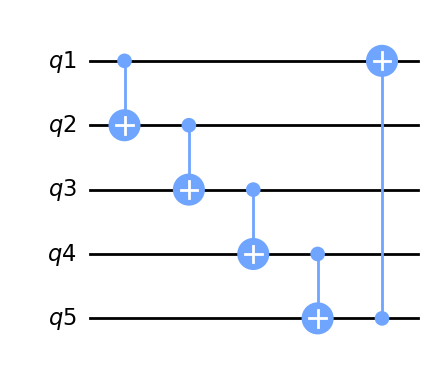

In [18]:
circuit.draw("mpl")

## QFT structure in one line!

In [12]:
qft = Qinit(n)  + (Qpivot(mapping=Qunitary("h()^0")) + Qpivot(mapping=Qunitary("cp(x)^01"), share_weights=False) + Qmask("1*"))*n

In [13]:
circuit= qft(backend=backend)

# We can set the parameters of the circuit using the assign_parameters method
# We set the parameters to be 2*pi*2^(-i-2) where i is the index of the controlled phase
params = {}
count = 0
i = 0
for p in circuit.parameters:
    params[p] = 2*np.pi*2**(-(i+2))
    i+=1
    if i == n-1-count:
        count += 1
        i = 0

## TODO fix for other libraries!
circuit = circuit.assign_parameters(params)

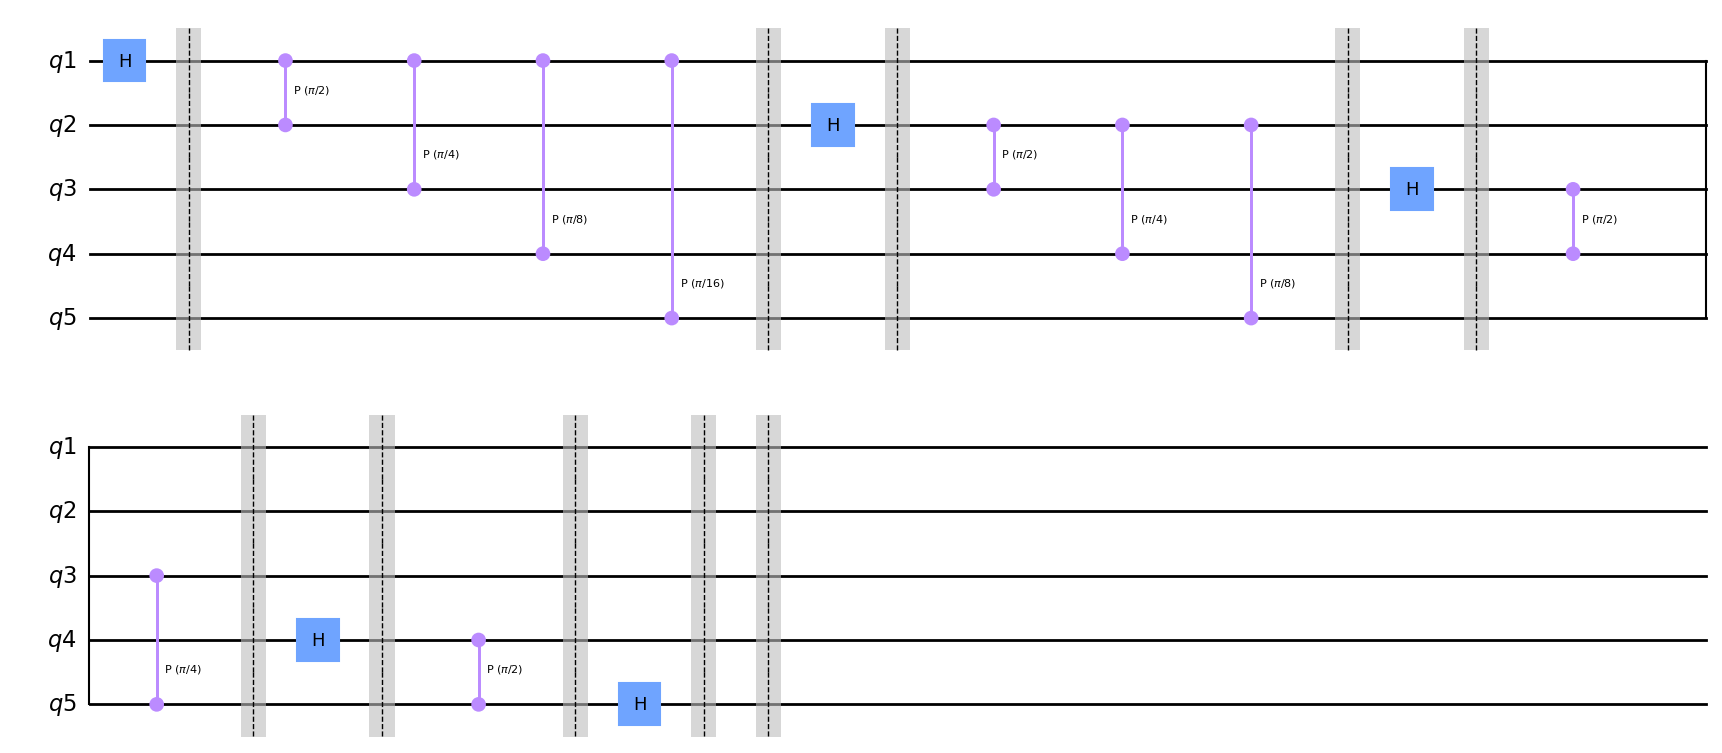

In [14]:
circuit.draw("mpl")

## Does this perform as intended?

It turns out that the circuit transforms the state $|0\rangle$ (understood as all qubits in state $|0\rangle$) to the state
$$\frac{1}{2^{\frac{n}{2}}} (|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle) \dots (|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle) (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )\,.$$ 
You may notice that in fact the order of the qubits is reversed compared to the theoretical QFT described earlier. This can be fixed by performing a series of "swap" operation. 

For simplicity we can assume that the user is aware that they should in fact read all output bit strings in reverse. (Note that Qiskitreadouts form the bottom to the top of the circuit, so this is  automatically taken care of if you are using the Qiskit library.) 

## Experiments

Zero intial state, equal superposition, random state -> compare to fft